---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [76]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels, get_local_model, batch_embed_local, batch_embed_openai, build_index, snowball_tokenize, search_bm25

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [114]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [ ]:
def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")


All functions defined!


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [36]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# Get a local embedding - first call downloads the model (~80MB)
model = get_local_model("all-MiniLM-L6-v2")
local_embs = {}
for word in words:
    local_embs[word] = model.encode(word, convert_to_numpy=True)

### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [37]:
# Implement cosine similarity from scratch
def cosine_similarity(a: np.array, b: np.array) -> float:  
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

num_words = len(words)
sim_matrix = np.zeros((num_words, num_words))

for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        sim_matrix[i, j] = cosine_similarity(local_embs[word1], local_embs[word2])

fsim_df = pd.DataFrame(sim_matrix, index=words, columns=words)
# Display as DataFrame
display(fsim_df)

,wooden coffee table,oak dining table,red leather sofa,blue area rug,kitchen sink
wooden coffee table,1.000000,0.588631,0.370622,0.189486,0.295712
oak dining table,0.588631,1.000000,0.337910,0.249521,0.341410
red leather sofa,0.370622,0.337910,1.000000,0.380310,0.057740
blue area rug,0.189486,0.249521,0.380310,1.000000,0.125802
kitchen sink,0.295712,0.341410,0.057740,0.125802,1.000000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [39]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Compare the dimension with the local model
# Compare dimensions
api_embs = {}
for word in words:
    response = litellm.embedding(model="text-embedding-3-small", input=word)
    api_embs[word] = np.array(response.data[0]["embedding"])


    print(f"OpenAI (API) for word/phrase {word}: {len(api_embs[word])} dimensions")
    print(f"MiniLM (Local) word/phrase {word}: {len(local_embs[word])} dimensions")

OpenAI (API) for word/phrase wooden coffee table: 1536 dimensions
MiniLM (Local) word/phrase wooden coffee table: 384 dimensions
OpenAI (API) for word/phrase oak dining table: 1536 dimensions
MiniLM (Local) word/phrase oak dining table: 384 dimensions
OpenAI (API) for word/phrase red leather sofa: 1536 dimensions
MiniLM (Local) word/phrase red leather sofa: 384 dimensions
OpenAI (API) for word/phrase blue area rug: 1536 dimensions
MiniLM (Local) word/phrase blue area rug: 384 dimensions
OpenAI (API) for word/phrase kitchen sink: 1536 dimensions
MiniLM (Local) word/phrase kitchen sink: 384 dimensions


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [ ]:
# Get a consistent sample
products_sample = products.sample(n=5000, random_state=42).reset_index(drop=True)
# Create text for embedding: combine name and class
products_sample['embed_text'] = (
    products_sample['product_name'].fillna('') + ' ' +
    products_sample['product_class'].fillna('')
)

Embedding products...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches: 100%|██████████| 157/157 [00:14<00:00, 10.72it/s]

Done in 14.7s
Embeddings shape: (5000, 384)


In [47]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

print("Embedding products...")
start = time.time()
product_embeddings = batch_embed_local(
    products_sample['embed_text'].tolist(),
    show_progress=True
)
print(f"Done in {time.time() - start:.1f}s")
print(f"Embeddings shape: {product_embeddings.shape}")
# YOUR CODE HERE


Embedding products...


Batches: 100%|██████████| 157/157 [00:14<00:00, 10.93it/s]

Done in 14.4s
Embeddings shape: (5000, 384)


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [53]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match
# Save embeddings so we don't have to recompute
import os

# Ensure target directory exists
os.makedirs('temp', exist_ok=True)
filename = 'hw4_embeddings'
np.save(f'temp/{filename}.npy', product_embeddings)
products_sample.to_csv(f'temp/{filename}.csv', index=False)
print("Saved embeddings and sample to 'temp/'")
loaded_embeddings = np.load(f'temp/{filename}.npy')
# Verify that the loaded embeddings match the saved ones
assert np.array_equal(product_embeddings, loaded_embeddings), "Loaded embeddings do not match saved embeddings!"
print("Loaded embeddings match the original embeddings.")
del loaded_embeddings

Saved embeddings and sample to 'temp/'
Loaded embeddings match the original embeddings.


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [66]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset
import tiktoken

def num_tokens_from_string(string: str, model_name: str) -> int:
    """Returns the number of tokens in a text string for a given model."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Apply to each row in products and count tokens for each string
full_texts = products['product_name'].fillna('') + ' ' + products['product_class'].fillna('')
total_tokens = full_texts.apply(lambda s: num_tokens_from_string(s, 'text-embedding-3-small')).sum()
cost = total_tokens / 10**6 * 0.02
print(f'Total Cost = {cost} dollars')


Total Cost = 0.01118794 dollars


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [ ]:
# Implement batch cosine similarity for efficiency

def batch_cosine_similarity(query_emb: np.ndarray, doc_embs: np.ndarray) -> np.ndarray:
    """
    Calculate the cosine similarity between a single query embedding and multiple document embeddings.

    Parameters:
        query_emb (np.ndarray): Query embedding of shape (embedding_dim,)
        doc_embs (np.ndarray): Matrix of document embeddings, shape (num_docs, embedding_dim)

    Returns:
        np.ndarray: Cosine similarity scores for each document, shape (num_docs,)
    """
    # Ensure the query embedding is unit-norm
    query_emb_normalized = query_emb / np.linalg.norm(query_emb)
    # Ensure each document embedding is unit-norm along axis 1
    doc_embs_normalized = doc_embs / np.linalg.norm(doc_embs, axis=1, keepdims=True)
    # Cosine similarities are the dot products of normalized embeddings
    similarities = np.dot(doc_embs_normalized, query_emb_normalized)
    return similarities

In [108]:
# Implement semantic search
def semantic_search_local(query, product_embeddings, products_df, k=10, model: str = "all-MiniLM-L6-v2"):
    """Search products using local embedding similarity."""
    # 1. Embed the query
    model = get_local_model(model)
    query_emb = model.encode(query, convert_to_numpy=True)
    
    # 2. Calculate similarity to all products
    similarities = batch_cosine_similarity(query_emb, product_embeddings)
    
    # 3. Get top-k indices
    top_k_idx = np.argsort(-similarities)[:k]
    
    # 4. Build results DataFrame
    results = products_df.iloc[top_k_idx].copy()
    results['similarity'] = similarities[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

In [ ]:
# Test semantic search
results = semantic_search_local("car", product_embeddings, products_sample)
results[['rank', 'product_name', 'product_class', 'similarity']]

,rank,product_name,product_class,similarity
2165,1,accessory type,NaN,0.383332
4040,2,a dirt bike with dirt lover coffee mug,Mugs & Teacups,0.303978
746,3,exucutive chair,NaN,0.303006
1709,4,everardo desk,NaN,0.293139
3483,5,zoomie kids motorcycle,Ride-On Toys,0.283812
2300,6,caruthers end table with storage,End Tables,0.263600
4943,7,laundry basket,NaN,0.263542
559,8,electric motorized kids ride on dirt bike,Ride-On Toys,0.245837
3083,9,graystone 45.5 '' metal full podium with wheels and storage,Lecterns & Podiums,0.244461
3842,10,degroot motorcycle,Decorative Objects,0.232319


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [113]:
# Implement Recall@k
def evaluate_search(
    search_func,
    queries_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    k: int = 10,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Evaluate search across all queries using Recall@k.

    Recall@k = (# relevant items found in top k) / (total # relevant items)

    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress

    Returns:
        DataFrame with query_id, query, and recall columns
    """
    results = []

    for _, row in queries_df.iterrows():
        query_id = row["query_id"]
        query_text = row["query"]

        search_results = search_func(query_text)
        product_ids = search_results["product_id"].tolist()[:k]

        # Recall calculation (grade > 0 = relevant)
        query_labels = labels_df[labels_df["query_id"] == query_id]
        relevant_ids = set(query_labels[query_labels["grade"] > 0]["product_id"])
        retrieved_ids = set(product_ids)
        recall = (
            len(retrieved_ids & relevant_ids) / len(relevant_ids)
            if relevant_ids
            else 0.0
        )

        results.append(
            {
                "query_id": query_id,
                "query": query_text,
                "recall": recall,
            }
        )

    results_df = pd.DataFrame(results)

    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean Recall@{k}: {results_df['recall'].mean():.4f}")

    return results_df


In [79]:
# Build BM25 index for comparison

index, doc_lengths = build_index(products_sample['embed_text'], snowball_tokenize)

# Filter queries to those with products in our sample
sample_product_ids = set(products['product_id'])
sample_labels = labels[labels['product_id'].isin(sample_product_ids)]
sample_query_ids = set(sample_labels['query_id'])
sample_queries = queries[queries['query_id'].isin(sample_query_ids)]

print(f"Queries with products in sample: {len(sample_queries)}")

Queries with products in sample: 480


In [81]:
# Evaluate both BM25 and semantic search on all queries
bm_results = evaluate_search(
    lambda q: search_bm25(q, index, products_sample, doc_lengths, k=10),
    queries,
    labels
)

semantic_results = evaluate_search(
    lambda q: semantic_search_local(q, product_embeddings, products_sample, k=10),
    queries,
    labels
)
# Calculate Recall@10 for each method

Evaluated 480 queries
Mean Recall@10: 0.0426
Evaluated 480 queries
Mean Recall@10: 0.0368


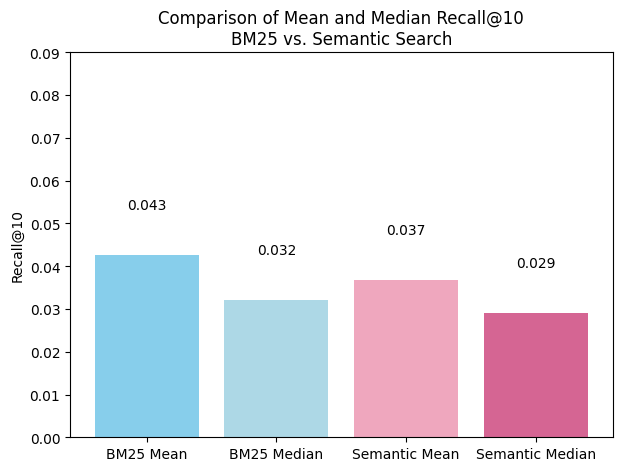

In [ ]:
# Visualize comparison
# Plot mean and median Recall@10 for BM25 and semantic search as a bar graph

# Compute mean and median recall for both methods
bm25_mean = bm_results["recall"].mean()
bm25_median = bm_results["recall"].median()
semantic_mean = semantic_results["recall"].mean()
semantic_median = semantic_results["recall"].median()

labels = ["BM25 Mean", "BM25 Median", "Semantic Mean", "Semantic Median"]
values = [bm25_mean, bm25_median, semantic_mean, semantic_median]
colors = ["skyblue", "lightblue", "#efa7be", "#d56593"]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=colors)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom', fontsize=10)
plt.ylim(0, .09)
plt.ylabel("Recall@10")
plt.title("Comparison of Mean and Median Recall@10\nBM25 vs. Semantic Search")
plt.show()

---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [101]:
# Load the two embedding models
model1_name = "BAAI/bge-base-en-v1.5"
model2_name = "sentence-transformers/all-mpnet-base-v2"
model1 = get_local_model(model1_name)
model2 = get_local_model(model2_name)

In [96]:
# Embed products with both models
product_texts = products_sample['embed_text'].tolist()
model1_emb = model1.encode(product_texts, convert_to_numpy=True, show_progress_bar=True)
model2_emb = model2.encode(product_texts, convert_to_numpy=True, show_progress_bar=True)


Batches: 100%|██████████| 157/157 [02:07<00:00,  1.24it/s]


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.


In [115]:
# Evaluate both models on all queries
# Fix shape mismatch by passing the correct model to semantic_search_local,
# so the query and product embeddings are aligned for each model.

model1_results = evaluate_search(
    lambda q: semantic_search_local(q, model1_emb, products_sample, k=10, model=model1_name),
    queries,
    labels
)

model2_results = evaluate_search(
    lambda q: semantic_search_local(q, model2_emb, products_sample, k=10, model=model2_name),
    queries,
    labels
)

Evaluated 480 queries
Mean Recall@10: 0.0376
Evaluated 480 queries
Mean Recall@10: 0.0357


In [132]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table", 'league of legends', 'games', 'computer games']
# Run semantic search for each model on test queries and show results
for q in test_queries:
    print(f"\nQuery: '{q}'")
    print(f"-- {model1_name} results:")
    display(semantic_search_local(q, model1_emb, products_sample, k=5, model=model1_name)[["product_name", "product_class", "similarity"]])
    print(f"-- {model2_name} results:")
    display(semantic_search_local(q, model2_emb, products_sample, k=5, model=model2_name)[["product_name", "product_class", "similarity"]])

# add more!


Query: 'comfortable sofa'
-- BAAI/bge-base-en-v1.5 results:


,product_name,product_class,similarity
2736,baeten patio sofa with cushions,NaN,0.808783
4741,94 '' square arm sofa with reversible cushions,NaN,0.804717
4800,mccaffery 74 '' round arm sofa,NaN,0.800535
723,sofa bed with ottoman,NaN,0.798662
865,86 '' rolled arm sofa with reversible cushions,NaN,0.797221


-- sentence-transformers/all-mpnet-base-v2 results:


,product_name,product_class,similarity
611,arshleen patio sofa with cushions,Patio Sofas,0.747831
964,aidann patio sectional with cushions,Patio Sofas,0.747359
250,lucey patio sectional with cushions,Patio Sofas,0.735517
147,phokas 93 '' square arm sofa,NaN,0.726604
1668,abrish patio sectional with cushions,Patio Sofas,0.725498



Query: 'star wars rug'
-- BAAI/bge-base-en-v1.5 results:


,product_name,product_class,similarity
4063,dinosaur land area rug,Area Rugs,0.778044
503,trisler hand-tufted gray/beige area rug,NaN,0.764771
2172,dunfries geometric shag gray/white area rug,NaN,0.759656
654,rihanna ikat plum area rug,Area Rugs,0.753444
951,sylvain oriental raspberry area rug,Area Rugs,0.748376


-- sentence-transformers/all-mpnet-base-v2 results:


,product_name,product_class,similarity
4368,runner brandt oriental hand-knotted wool beige area rug,Area Rugs,0.613816
1017,rugsotic carpets hand-knotted silk blue area rug,Area Rugs,0.612227
1032,novelty shayne patchwork cowhide leather gradient gray rug,Area Rugs,0.608988
4836,rhodes stripped checker 3 piece hand-knotted beige area rug set,Area Rugs,0.603813
4439,laguerre hooked wool blue/green area rug,NaN,0.603477



Query: 'modern coffee table'
-- BAAI/bge-base-en-v1.5 results:


,product_name,product_class,similarity
2860,coffee table with storage,NaN,0.850943
586,florie solid coffee table,NaN,0.845395
3630,tacto solid wood block coffee table,NaN,0.820254
3036,rodarte abstract coffee table with storage,NaN,0.817309
695,updegraff contemporary rect coffee table,Coffee & Cocktail Tables,0.814997


-- sentence-transformers/all-mpnet-base-v2 results:


,product_name,product_class,similarity
3754,coffee table,Coffee & Cocktail Tables,0.829269
695,updegraff contemporary rect coffee table,Coffee & Cocktail Tables,0.808302
3839,choual coffee table,Coffee & Cocktail Tables,0.804747
3585,hodgson coffee table,Coffee & Cocktail Tables,0.804061
3053,bettrys coffee table,Coffee & Cocktail Tables,0.800854



Query: 'league of legends'
-- BAAI/bge-base-en-v1.5 results:


,product_name,product_class,similarity
2393,pc and racing game chair,Game Chairs,0.583434
3446,ergonomic gaming chair with footrest and massage,Game Chairs|Office Chairs,0.560467
1650,high-level office gaming chair,Game Chairs|Office Chairs,0.547367
1211,office ergonomic gaming chair,Game Chairs|Office Chairs,0.544811
1082,chicane rocker,Game Chairs,0.533027


-- sentence-transformers/all-mpnet-base-v2 results:


,product_name,product_class,similarity
2393,pc and racing game chair,Game Chairs,0.338793
1232,outdoor pickleballs,Lawn Games,0.300162
58,sling float pool noodle,Lawn Games,0.295847
4080,crosstown eat sleep climb passionate rock climber text climbing sport hobby ...,Kitchen Towels,0.290147
4249,floating beer pong table,Beer Pong,0.289531



Query: 'games'
-- BAAI/bge-base-en-v1.5 results:


,product_name,product_class,similarity
4794,pool float,Lawn Games,0.684048
2837,lazy lounger pool float,Lawn Games,0.683994
1232,outdoor pickleballs,Lawn Games,0.682412
2393,pc and racing game chair,Game Chairs,0.680471
58,sling float pool noodle,Lawn Games,0.677976


-- sentence-transformers/all-mpnet-base-v2 results:


,product_name,product_class,similarity
2393,pc and racing game chair,Game Chairs,0.514488
2837,lazy lounger pool float,Lawn Games,0.419043
4794,pool float,Lawn Games,0.397346
225,petz hippo float inflatables,Lawn Games,0.393817
58,sling float pool noodle,Lawn Games,0.391865



Query: 'computer games'
-- BAAI/bge-base-en-v1.5 results:


,product_name,product_class,similarity
2393,pc and racing game chair,Game Chairs,0.706838
1211,office ergonomic gaming chair,Game Chairs|Office Chairs,0.647155
2837,lazy lounger pool float,Lawn Games,0.630353
1650,high-level office gaming chair,Game Chairs|Office Chairs,0.625424
4794,pool float,Lawn Games,0.618685


-- sentence-transformers/all-mpnet-base-v2 results:


,product_name,product_class,similarity
2393,pc and racing game chair,Game Chairs,0.592568
1211,office ergonomic gaming chair,Game Chairs|Office Chairs,0.433552
1650,high-level office gaming chair,Game Chairs|Office Chairs,0.432347
2837,lazy lounger pool float,Lawn Games,0.410068
3446,ergonomic gaming chair with footrest and massage,Game Chairs|Office Chairs,0.381717


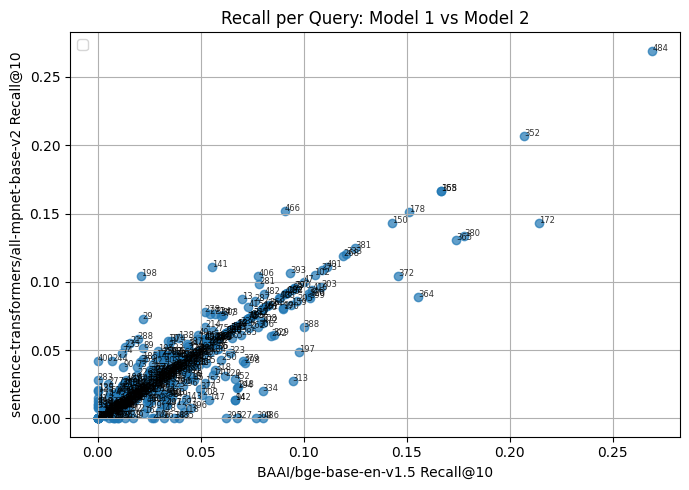

In [130]:
# Extract recall (recall@10 or fallback to recall) per query
model1_recall = model1_results['recall'].tolist()
model2_recall = model2_results['recall'].tolist()

plt.figure(figsize=(7, 5))
plt.scatter(model1_recall, model2_recall, alpha=0.7)

# Optionally, annotate per query
for i, txt in enumerate(model1_results['query_id']):
    plt.annotate(str(txt), (model1_recall[i], model2_recall[i]), fontsize=6, alpha=0.8)

plt.xlabel(f'{model1_name} Recall@10')
plt.ylabel(f'{model2_name} Recall@10')
plt.title('Recall per Query: Model 1 vs Model 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.